In [1]:
import heapq as hq
import pandas as pd
import torch
import optuna
from bokeh.io import output_notebook, show, export_svg
from bokeh.layouts import row
output_notebook()
from sklearn.metrics import mean_squared_error
from models import GNN_model
from utils.functions import get_spec_prediction, calculate_rse, bokeh_spectra
from dataset import XASMolDataset

Loading BokehJS ...

In [2]:
gnn_type = 'gcn'

study_name = gnn_type + '_study'
storage_name = 'sqlite:///tune_studies/orig/{}.db'.format(study_name)

study = optuna.load_study(study_name=study_name, storage=storage_name)

In [3]:
best = study.best_trial
print(f'Best model: {best.number}')
print(f'Best validation loss: {best.value:.5f}')
print('-----')
gnn_params = {}
for key, value in best.params.items():
    print(f'{key}: {value}')
    gnn_params[key] = value

Best model: 37
Best validation loss: 0.00506
-----
num_layers: 3
hidden_channels: 256
gnn_type: gcn
drop_ratio: 0.5
learning_rate: 0.0024114371156205155


In [4]:
num_tasks = 200
num_layers = gnn_params['num_layers']
hidden_channels = gnn_params['hidden_channels']
in_channels = [hidden_channels] * (num_layers - 1)
in_channels.insert(0, 12)
out_channels = [hidden_channels] * num_layers
gnn_type = gnn_params['gnn_type']
heads = 1
drop_ratio = gnn_params['drop_ratio']
graph_pooling = 'mean'


model  = GNN_model(num_tasks, num_layers, in_channels, out_channels,
                   gnn_type, heads, drop_ratio, graph_pooling)

In [6]:
model.load_state_dict(torch.load('./models/orig/'+gnn_params['gnn_type']+'_model.pth', map_location='cpu'))
# model.load_state_dict(torch.load('./gcn_test.pth', map_location='cpu'))

/tmp/ipykernel_69293/1655677706.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/orig/'+gnn_params['gnn_type']+'_model.pth', ma

<All keys matched successfully>

In [7]:
test_dataset = torch.load('../processed/test_coronene_pyg.pt')
print(test_dataset[0])

Data(x=[31, 12], edge_index=[2, 76], edge_attr=[76, 5], spectrum=[200], idx=[1], smiles='c12[c:2]3[c:1]([H:39])[c:23]([O:26][H:37])[c:22]4[c:20]1[c:16]1[c:12]5[c:8]6[c:4]2[c:6]([c:5]([C:25](=[O:29])[H:42])[c:3]3[H:41])[c:7]([H:31])[c:9]([H:32])[c:10]6[C:11]([H:40])=[C:13]([C:24](=[O:30])[H:43])[C:14]52[C:15]([H:33])([C:17]([H:34])([H:44])[C:18]1([O:27][H:38])[C:19]([H:35])=[C:21]4[H:36])[O:28]2')


/tmp/ipykernel_69293/4095939695.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_dataset = torch.load('../processed/test_coronene_pyg.pt')


In [8]:
pred = {}
true = {}
device = 'cpu'

for index, data in enumerate(test_dataset):
    pred[index], true[index] = get_spec_prediction(model, data, device)

In [9]:
mse = []
rse = []

for x in range(len(pred)):
    mse_temp = mean_squared_error(true[x], pred[x])
    mse.append(mse_temp)
    rse_temp = calculate_rse(pred[x], true[x])
    rse.append(rse_temp)

ave_mse = sum(mse) / len(mse)
ave_rse = sum(rse) / len(rse)

print(f'Average MSE = {ave_mse}')
print(f'Average RSE = {ave_rse}')

Average MSE = 0.005869186483323574
Average RSE = 0.031094998121261597


In [10]:
rank_rse = hq.nsmallest(len(rse), rse)

rank_graph = []

for x in range(len(rse)):
    rank_idx = rse.index(rank_rse[x])
    rank_graph.append(rank_idx)

print('The 5 best RSE values are:')
for i in range(5):
    print(f'RSE = {rank_rse[i]:.3f}, graph number = {rank_graph[i]}')
print('')
print('The 5 worst RSE values are:')
for i in range(-1, -6, -1):
    print(f'RSE = {rank_rse[i]:.3f}, graph number = {rank_graph[i]}')


The 5 best RSE values are:
RSE = 0.014, graph number = 0
RSE = 0.015, graph number = 7
RSE = 0.017, graph number = 29
RSE = 0.017, graph number = 30
RSE = 0.020, graph number = 47

The 5 worst RSE values are:
RSE = 0.064, graph number = 50
RSE = 0.055, graph number = 21
RSE = 0.046, graph number = 42
RSE = 0.044, graph number = 10
RSE = 0.043, graph number = 24


In [11]:
# Plot best spectra predictions
p1 = bokeh_spectra(pred[rank_graph[0]], true[rank_graph[0]])
p2 = bokeh_spectra(pred[rank_graph[1]], true[rank_graph[1]])
p3 = bokeh_spectra(pred[rank_graph[2]], true[rank_graph[2]])
p = row(p1, p2, p3)
show(p)

In [12]:
# Plot worst spectra predictions
p1 = bokeh_spectra(pred[rank_graph[-1]], true[rank_graph[-1]])
p2 = bokeh_spectra(pred[rank_graph[-2]], true[rank_graph[-2]])
p3 = bokeh_spectra(pred[rank_graph[-3]], true[rank_graph[-3]])
p = row(p1, p2, p3)
show(p)

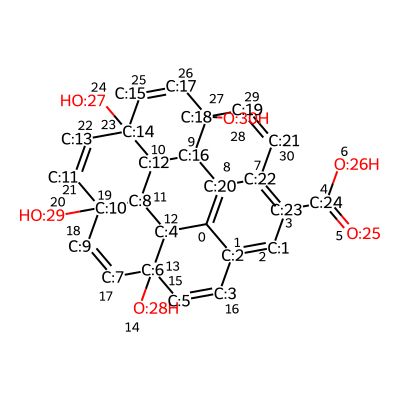

In [16]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

# --- View molecule using RDKit
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.8
IPythonConsole.molSize = 400,400
mol = Chem.MolFromSmiles(test_dataset[77].smiles)
mol

In [66]:
# Create or open results dataframe
# df = pd.DataFrame(rse, columns=[gnn_params['gnn_type']])
df = pd.read_pickle('./RSE/coronene_rse_values.pkl')

df[gnn_params['gnn_type']] = rse

df.to_pickle('./RSE/coronene_rse_values.pkl')

In [10]:
path = '../'
cir_dataset = XASMolDataset(path)
print(cir_dataset)

XASMolDataset(92)


/home/samjhall/miniconda3/envs/pyg-schnet/lib/python3.11/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) an

In [24]:
for x in cir_dataset:
    print(x)

Data(x=[57, 15], edge_index=[2, 156], edge_attr=[156, 5], spectrum=[200], idx=[1], smiles='c12[c:1]3[c:2]4[c:3]([c:4]([H:57])[c:5]1[H:58])=[C:38]([H:71])[C:39]15[C:40]6([c:9]4[c:8]4[c:7]7[c:6]3[c:24]3[c:23]([c:22]2[H:61])[c:31]([H:62])[c:32]([H:63])[c:33]2[c:25]3[c:26]3[c:10]7[c:11]7[c:12]8[c:13]4[c:42]4[c:43]9[c:44]%10[c:17]8[c:16]8[c:15]%11[c:14]7[C:28]7%12[C:27]3([C:35](=[C:34]2[H:64])[C:36]([H:73])=[C:37]([H:74])[C:29]7=[C:30]([H:72])[c:18]%11[c:19]([H:59])[c:20]([H:60])[c:21]8[c:46]([H:65])[c:45]%10[c:53]([H:70])[c:52]([H:69])[c:51]9=[C:50]([H:68])[C:49]2([C:41]64[O:54]2)[C:48]([H:67])=[C:47]1[H:66])[O:55]%12)[O:56]5', mol='cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_3_ieEPOXY_0_2')
Data(x=[58, 15], edge_index=[2, 160], edge_attr=[160, 5], spectrum=[200], idx=[1], smiles='c12[c:1]3[c:2]4[c:3]([c:4]([H:58])[c:5]1[H:59])[c:38]([H:77])[c:39]1[c:40]5[c:9]4[c:8]4[c:7]6[c:6]3[C:24]37[C:23]([C:22]2([H:62])[H:69])([C:31]([H:63])=[C:32]([H:64])[C:33]2=[C:34]([H:65])[c:35]8[c:

In [11]:
cir_pred = {}
cir_true = {}
device = 'cpu'

for index, data in enumerate(cir_dataset):
    cir_pred[index], cir_true[index] = get_spec_prediction(model, data, device)

In [12]:
cir_mse = []
cir_rse = []

for x in range(len(cir_pred)):
    mse_temp = mean_squared_error(cir_true[x], cir_pred[x])
    cir_mse.append(mse_temp)
    rse_temp = calculate_rse(cir_pred[x], cir_true[x])
    cir_rse.append(rse_temp)

cir_ave_mse = sum(cir_mse) / len(cir_mse)
cir_ave_rse = sum(cir_rse) / len(cir_rse)

print(f'Average MSE = {cir_ave_mse}')
print(f'Average RSE = {cir_ave_rse}')

Average MSE = 0.0072257863357663155
Average RSE = 0.05723867192864418


In [13]:
cir_rank_rse = hq.nsmallest(len(cir_rse), cir_rse)

cir_rank_graph = []

for x in range(len(cir_rse)):
    cir_rank_idx = cir_rse.index(cir_rank_rse[x])
    cir_rank_graph.append(cir_rank_idx)

print('The 5 best RSE values are:')
for i in range(5):
    print(f'RSE = {cir_rank_rse[i]:.3f}, graph number = {cir_rank_graph[i]}')
print('')
print('The 5 worst RSE values are:')
for i in range(-1, -6, -1):
    print(f'RSE = {cir_rank_rse[i]:.3f}, graph number = {cir_rank_graph[i]}')

The 5 best RSE values are:
RSE = 0.035, graph number = 11
RSE = 0.036, graph number = 29
RSE = 0.041, graph number = 43
RSE = 0.042, graph number = 47
RSE = 0.042, graph number = 14

The 5 worst RSE values are:
RSE = 0.083, graph number = 1
RSE = 0.082, graph number = 6
RSE = 0.081, graph number = 7
RSE = 0.080, graph number = 22
RSE = 0.079, graph number = 30


In [14]:
# Plot best spectra predictions
p1 = bokeh_spectra(cir_pred[cir_rank_graph[0]], cir_true[cir_rank_graph[0]])
p2 = bokeh_spectra(cir_pred[cir_rank_graph[1]], cir_true[cir_rank_graph[1]])
p3 = bokeh_spectra(cir_pred[cir_rank_graph[2]], cir_true[rank_graph[2]])
p = row(p1, p2, p3)
show(p)

In [15]:
# Plot worst spectra predictions
p1 = bokeh_spectra(cir_pred[cir_rank_graph[-1]], cir_true[cir_rank_graph[-1]])
p2 = bokeh_spectra(cir_pred[cir_rank_graph[-2]], cir_true[cir_rank_graph[-2]])
p3 = bokeh_spectra(cir_pred[cir_rank_graph[-3]], cir_true[rank_graph[-3]])
p = row(p1, p2, p3)
show(p)